In [62]:
import omegaconf
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ultk.effcomm.rate_distortion import ib_encoder_to_point

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")
from game.game import Game

from tqdm import tqdm


In [2]:
# Fix one param config

parent = Path("/Users/nathanielimel/uci/projects/ibsg/multirun/universe=100/num_signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=imprecise_conditional_imitation/ii=0/discr_need=0/population_init=0/population_size=None/num_runs=1/seed=0")

config = omegaconf.OmegaConf.load(parent / ".hydra/config.yaml")
g = Game.from_hydra(config)

In [3]:
# bound data
betas = np.load('/Users/nathanielimel/uci/projects/ibsg/multirun/universe=100/num_signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/betas.npy')

optimal_encoders = np.load('/Users/nathanielimel/uci/projects/ibsg/multirun/universe=100/num_signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/optimal_encoders.npy')

curve_data = pd.read_csv('/Users/nathanielimel/uci/projects/ibsg/multirun/universe=100/num_signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/curve_points.csv')


# simulation data

emergent_encoders = np.load('/Users/nathanielimel/uci/projects/ibsg/multirun/universe=100/num_signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=imprecise_conditional_imitation/ii=0/discr_need=0/population_init=0/population_size=None/num_runs=1/seed=0/final_encoders.npy')

sim_data = pd.read_csv('/Users/nathanielimel/uci/projects/ibsg/multirun/universe=100/num_signals=100/prior=-8/dist=squared_dist/meaning_certainty=0/dynamics=imprecise_conditional_imitation/ii=0/discr_need=0/population_init=0/population_size=None/num_runs=1/seed=0/simulation_points.csv')


In [4]:
curve_points = curve_data[["complexity", "accuracy"]].values

In [5]:
# Measure efficiency loss 1/beta (F_emergent - F_optimal) to any F_optimal
# F_[q] = em_complexity - em_acc
# eps = 1/beta * ( F_[q] - F_[q*] )
F_opt = curve_points[:,0] - betas * curve_points[:,1]

for em in tqdm(emergent_encoders, desc="looping over encoders"):
    comp, acc, _ = ib_encoder_to_point(g.prior, g.meaning_dists, em)
    F_em = comp - betas * acc

    # Do we have F_[q] >= F_[q*] for all q?
    F_em_deviation = F_em - F_opt
    min_ind = np.argmin(F_em_deviation)

    beta_em = betas[min_ind]
    epsilon_em = np.min(F_em_deviation) / beta_em
    fitted_opt = optimal_encoders[min_ind]


    if epsilon_em < 0:
        print(epsilon_em)
        assert False


fitting final encoders:   0%|          | 0/1 [00:00<?, ?it/s]

-0.0775858878635856


AssertionError: 

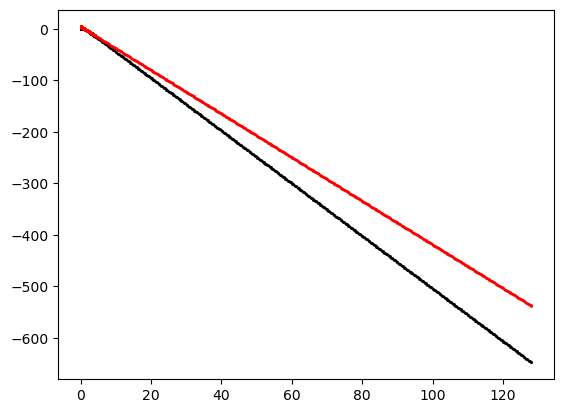

In [6]:
plt.scatter(betas, F_opt, color="black", s=1)
plt.scatter(betas, F_em, color="red", s=1)
plt.show()

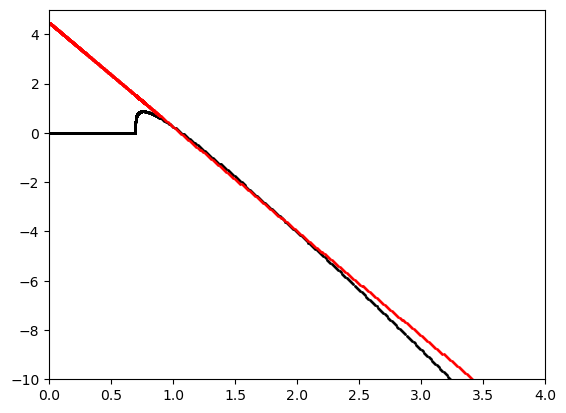

In [ ]:
plt.scatter(betas, F_opt, color="black", s=1)
plt.scatter(betas, F_em, color="red", s=1)
plt.xlim(0,4)
plt.ylim(-10, 5)
plt.show()

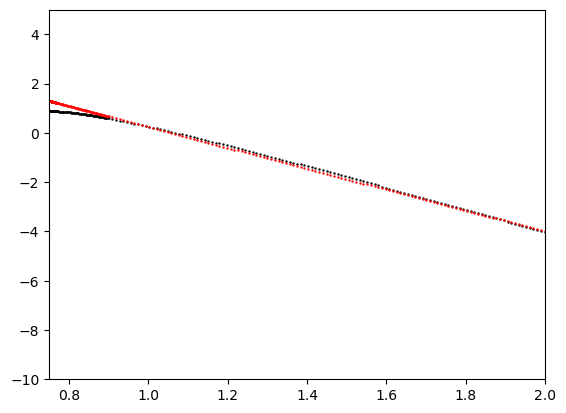

In [57]:
plt.scatter(betas, F_opt, color="black", s=0.5)
plt.scatter(betas, F_em, color="red", s=0.5)
plt.xlim(0.75,2)
plt.ylim(-10, 5)
plt.show()

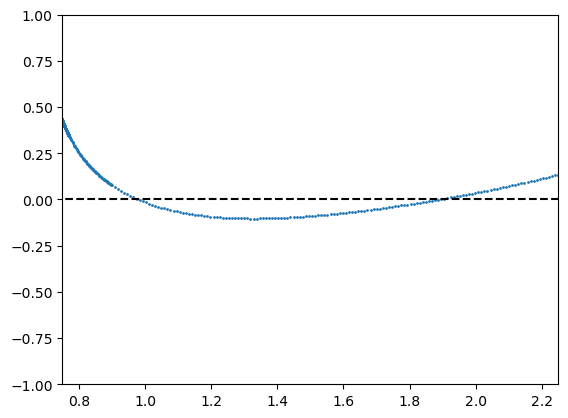

In [10]:
plt.scatter(betas, F_em - F_opt, s=1)
plt.hlines(0, 0, 4, color="black", linestyles='dashed')
plt.xlim(0.75,2.25)
plt.ylim(-1, 1)
plt.show()

Ruling out that the source is numerical instability in the region $\beta = [1.0,2.0]$

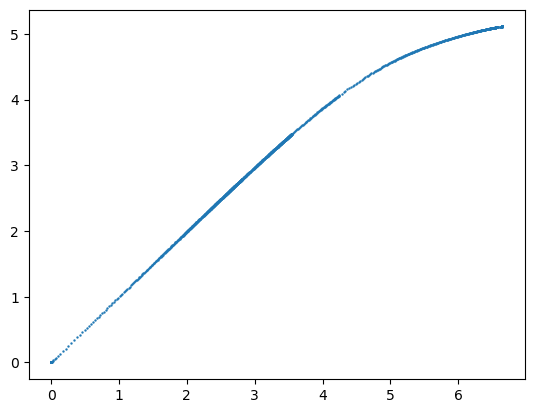

In [51]:
plt.scatter(*curve_points.T, s=0.5)

(0.8, 2.2)

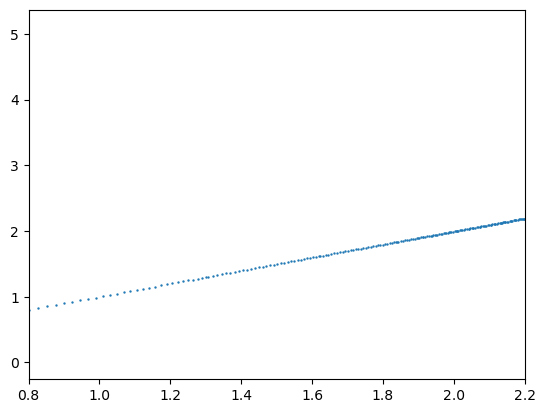

In [52]:
plt.scatter(*curve_points.T, s=0.5)
plt.xlim(0.8, 2.2)

(0.5, 2.0)

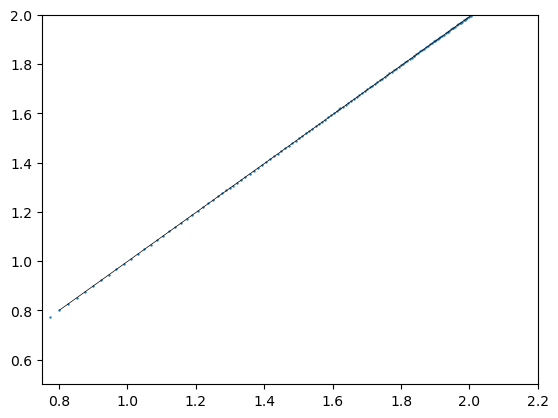

In [56]:
# Idea draw a line between the y value at 0.8 and the y value at 2.0, and check if the blue line is below it.
import numpy as np
np.set_printoptions(suppress=True)
index1 = 620
index2 = 800
xy1 = curve_points[index1]
xy2 = curve_points[index2]
plt.scatter(*curve_points.T, s=0.5)
plt.plot([xy1[0], xy2[0]], [xy1[1], xy2[1]], color="black", linewidth=0.5)
plt.xlim(0.75, 2.2)
plt.ylim(0.5,2)

Ruling out that the source of trouble is from an encoder that doesn't sum to 1.0

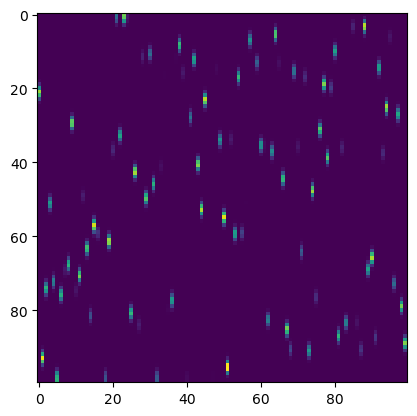

In [ ]:
plt.imshow(em)
plt.show()

In [ ]:
em.sum(1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
comp, acc

(4.476913891979038, 4.234739759654346)

### Digression unrelated to debugging (ignore this section)
visualizing centroids

In [79]:
encoder = em

modes = []
for word_idx, word_vec in enumerate(encoder.T):
    meaning_idx = np.argmax(word_vec)
    xy = (word_idx, meaning_idx)
    modes.append(xy)

import plotnine as pn
import pandas as pd
data = pd.DataFrame(modes, columns=["word", "meaning"])

# now need the regular encoder as df and plot
from misc.util import encoders_to_df

og_df = encoders_to_df(encoder[None,:])

from misc.vis import basic_encoder_lineplot


(
    pn.ggplot(og_df, pn.aes(x="meaning", y="p"))
    + pn.geom_line(
        mapping=pn.aes(
            color="word",
        ),
        size=1,
    )
    + pn.ylim([0, 1])
)

og_df

,run,word,meaning,naming probability \n,p
0,0.0,0.0,0.0,1.351811e-80,1.351811e-80
1,0.0,1.0,0.0,0.000000e+00,0.000000e+00
2,0.0,2.0,0.0,0.000000e+00,0.000000e+00
3,0.0,3.0,0.0,0.000000e+00,0.000000e+00
4,0.0,4.0,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...
9995,0.0,95.0,99.0,0.000000e+00,0.000000e+00
9996,0.0,96.0,99.0,1.443069e-122,1.443069e-122
9997,0.0,97.0,99.0,0.000000e+00,0.000000e+00
9998,0.0,98.0,99.0,3.052308e-72,3.052308e-72


In [ ]:
# something like the following 

# data = []
# for word in words:
#   modal_meaning = argmax(word_vector)
#   data.append(
#       (word, modal_meaning, )
# )
# 

# That is not going to work. 
# You need, for every point on the x-axis, the following things:
# the probability of using word i
# and the word identity 


# idk wtf i'm doing, need to ask noga.